In [4]:
import pandas as pd 
import anndata as ad 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import math
import os
from matplotlib import cm
import crested
import keras
from IPython.display import display

%matplotlib inline 

In [ ]:
pd.set_option('display.max_columns', None)

## REGISTER THE GENOME:
genome_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"
genome = crested.Genome(genome_path)
crested.register_genome(genome)

## CHARGE THE MODEL:
model_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/human/99.keras"
model = keras.models.load_model(model_path, compile = False)

adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/crested_adata/human_basalganglia_hmba_pre-print_crested.h5ad")

2025-07-26T18:17:26.005202-0700 INFO Genome genome registered.


2025-07-26 18:17:26.019706: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
def get_mutation(ref_nucleotide, effect_allele, other_allele):
    """
    Determines the mutated nucleotide based on the reference nucleotide and the alleles (effect and other).
    
    Parameters:
    ref_nucleotide (str): The reference nucleotide from the genome sequence.
    effect_allele (str): The effect allele.
    other_allele (str): The other allele.
    
    Returns:
    str or None: The mutated nucleotide if the mutation is valid, otherwise None.
    """
    
    if ref_nucleotide == effect_allele:
        print("Reference nucleotide is on the effect allele.")
        return other_allele  # Mutation is the 'other' allele
    elif ref_nucleotide == other_allele:
        print("Reference nucleotide is on the other allele.")
        return effect_allele  # Mutation is the 'effect' allele
    else:
        print("Reference nucleotide does not match either allele.")
        return None  # Invalid mutation or alignment issue

In [ ]:
def get_snp_info(snp_id, pheno, peaks_df):
    """
    Returns a dict with the info on a given SNP: chr, position, effect/other alleles, start/end of the overlapping peak.
    
    """
    row = peaks_df.loc[peaks_df["rsid"] == snp_id]
    if row.empty:
        print(f"SNP {snp_id} not found in the dataframe.")
        return None

    if pheno in ["SCZ", "PTSD"]:
        effect_allele = row["A1"].values[0]
        other_allele = row["A2"].values[0]
    elif pheno == "Alzheimer":
        effect_allele = row["effect_allele"].values[0]
        other_allele = row["other_allele"].values[0]
    elif pheno == "Depression":
        effect_allele = row["EA"].values[0]
        other_allele = row["NEA"].values[0]
    else:
        print(f"Unknown phenotype '{pheno}': cannot extract alleles.")
        return None

    return {
        "chrom": row["peak_chr"].values[0],
        "start": row["peak_start"].values[0],
        "end": row["peak_end"].values[0],
        "snp_pos": int(row["snp_end_POS_hg38"].values[0]),
        "effect_allele": effect_allele,
        "other_allele": other_allele,
    }



In [ ]:
def get_sequence_and_ref(chrom, start, end, snp_pos, genome):
    
    """ Extracts the reference sequence for a given peak"""

    sequence = genome.fetch(chrom, start - 1, end - 1)
    sequence_list = list(sequence)

    SNP_index = snp_pos - start
    if SNP_index < 0 or SNP_index >= len(sequence_list):
        print("SNP outside peak boundaries.")
        return None, None, None

    ref_nucleotide = genome.fetch(chrom, snp_pos - 1, snp_pos)

    if ref_nucleotide != sequence_list[SNP_index]:
        print("Coordinates not aligned.")
        return None, None, None

    return sequence_list, SNP_index, ref_nucleotide

In [ ]:
def apply_mutation_to_sequence(sequence_list, snp_index, mutation):

    """ 
    Mutates the reference sequence with the alternative allele 
    
    """
    
    mutated = sequence_list.copy()
    mutated[snp_index] = mutation
    mutated_seq = "".join(mutated)
    if len(mutation) > 1:
        mutated_seq = mutated_seq[:-1]  # adjust length if there is an indel
    return mutated_seq

In [12]:
def plot_predictions_and_contribs(sequence, mutated_sequence, snp_index, class_name, model, adata):

    """ Plot the contribution scores of the sequence before and after the mutation """

    target_idx = list(adata.obs_names).index(class_name)
    class_names = list(adata.obs_names)

    original_pred = np.squeeze(crested.tl.predict(sequence, model))
    mutated_pred = np.squeeze(crested.tl.predict(mutated_sequence, model))
    delta = mutated_pred - original_pred

    #crested.pl.bar.prediction(original_pred, classes=class_names)

    scores, one_hot = crested.tl.contribution_scores(sequence, target_idx=target_idx, model=model, method='integrated_grad')
    crested.pl.patterns.contribution_scores(scores, one_hot, class_labels=[""], zoom_n_bases=500,
                                            method='integrated_grad', highlight_positions=[[snp_index - 5, snp_index + 5]])

    mutated_scores, mutated_one_hot = crested.tl.contribution_scores(mutated_sequence, target_idx=target_idx, model=model, method='integrated_grad')
    crested.pl.patterns.contribution_scores(mutated_scores, mutated_one_hot, class_labels=[""], zoom_n_bases=500,
                                            method='integrated_grad', highlight_positions=[[snp_index - 5, snp_index + 5]])

Reference nucleotide is on the effect allele.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2025-07-26T18:40:25.954515-0700 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


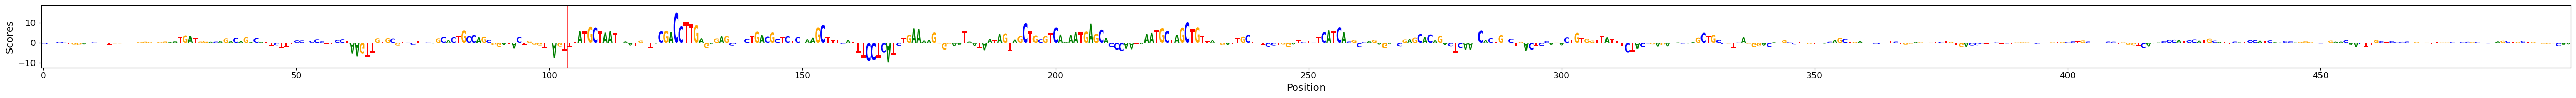

2025-07-26T18:40:33.900629-0700 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


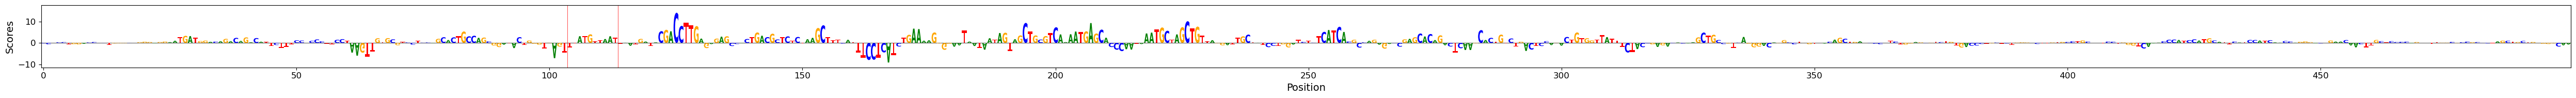

In [17]:
pheno = "SCZ"
cell_type = "GPe_MEIS2-SOX6_GABA" #"STR_SST-RSPO2_GABA" #"WM" #"GPe_MEIS2-SOX6_GABA" #"LAMP5-CXCL14_GABA" #"GPe_MEIS2-SOX6_GABA" #"STR_SST-RSPO2_GABA" #"STR_TAC3-PLPP4_GABA" #"STRv_D1_NUDAP_MSN" #"STR_SST-RSPO2_GABA" #"SN_SOX6_Dopa" #"GPe_MEIS2-SOX6_GABA" #"STRd_D2_Striosome_MSN" #"STRv_D2_MSN"
class_name = "GPe_MEIS2-SOX6_GABA" #"STR_SST-RSPO2_GABA" #"WM" #"GPe_MEIS2-SOX6_GABA" #"LAMP5-CXCL14_GABA" #"GPe_MEIS2-SOX6_GABA"  #"STR_SST-RSPO2_GABA" #"STR_TAC3-PLPP4_GABA" #"STRv_D1_NUDAP_MSN" #"STR_SST-RSPO2_GABA" #"SN_SOX6_Dopa" #"GPe_MEIS2-SOX6_GABA" #"STRd_D2_Striosome_MSN" #"STRv_D2_MSN"
snp = "rs1883123"

peaks_below_500 = pd.read_csv(f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/CRESTED_analysis/CRESTED_peaks/snps_peaks_selection_CRESTED_method/snps_peaks_BG/{pheno}/{pheno}_{cell_type}_peaks.tsv", sep = "\t")


info = get_snp_info(snp, pheno, peaks_below_500)
if info is not None:

    seq_list, snp_idx, ref_nuc = get_sequence_and_ref(info["chrom"], info["start"], info["end"], info["snp_pos"], genome)
    if seq_list is not None:

        mutation = get_mutation(ref_nuc, info["effect_allele"], info["other_allele"])
        if mutation is not None:

            mutated_seq = apply_mutation_to_sequence(seq_list, snp_idx, mutation)
            plot_predictions_and_contribs("".join(seq_list), mutated_seq, snp_idx, class_name, model, adata)


### Comparison with the effects of the other nucleotides' mutation

In [ ]:
def mutation_all_central_bases(original_pred, mutated_pred, sequence, mutated_sequence, cell_type, adata, ref_base, mutation):

    nucleotides = ["A", "C", "G", "T"]
    snp_index = SNP_position - start

    window_size = 500
    half_window = window_size // 2
    sequence_length = len(sequence)

    start_idx = max(0, snp_index - half_window)
    end_idx = min(sequence_length, snp_index + half_window)
    print(start_idx)
    print(end_idx)

    positions_to_test = [i for i in range(start_idx, end_idx) if i != snp_index]

    # Real SNP, already computed
    real_delta = mutated_pred - original_pred
    random_deltas = []

    for pos in positions_to_test:
        base_at_pos = sequence[pos]

        for alt_base in [b for b in nucleotides if b != base_at_pos]:
            seq_list = list(sequence)
            seq_list[pos] = alt_base
            mutated_seq = "".join(seq_list)

            pred = np.squeeze(crested.tl.predict(mutated_seq, model))
            delta = pred - original_pred
            random_deltas.append(delta)

    random_deltas = np.array(random_deltas)

    # Differential effect for the target cell type
    target_idx = list(adata.obs_names).index(cell_type)
    real_diff = real_delta[target_idx] - np.mean(np.delete(real_delta, target_idx))

    random_diffs = [
        delta[target_idx] - np.mean(np.delete(delta, target_idx))
        for delta in random_deltas
    ]
    random_diffs = np.array(random_diffs)


    ## Test the effect of the other mutations at the position of the SNP:
    remaining_bases = [b for b in nucleotides if b != ref_base and b != mutation]
    control_deltas = []
    control_labels = []

    for b in remaining_bases :
        control_seq_list = list(sequence)
        control_seq_list[snp_index] = b
        control_mut_seq = "".join(control_seq_list)
        control_pred = np.squeeze(crested.tl.predict(control_mut_seq, model))
        control_delta = control_pred - original_pred
        control_diff = control_delta[target_idx] - np.mean(np.delete(control_delta, target_idx))
        control_deltas.append(control_diff)
        control_labels.append(f"{ref_base}→{b}")


    # Histogramme
    plt.hist(random_diffs, bins=30, alpha=0.7, label="Random Δ (target - others)")

    # Ligne rouge = vraie mutation
    plt.axvline(real_diff, color="red", linestyle="--", label=f"Real SNP Δ, {ref_base}→{mutation}")

    # Lignes colorées pour les deux autres mutations au même site
    colors = ["#1f77b4", "#2ca02c"]  # bleu, vert
    for diff, label, color in zip(control_deltas, control_labels, colors):
        plt.axvline(diff, color=color, linestyle="-.", label=label)

    # Finitions
    plt.title(f"Enrichment in {cell_type}")
    plt.xlabel("Δ prediction score (target - others)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/figures/CRESTED_figures/Randomization_mutations_{snp}_{pheno}_{cell_type}.svg")
    plt.show()

    for label, val in zip(control_labels, control_deltas):
        print(f"Δ control ({label}) = {val:.4f}")

In [ ]:
def plot_variant_specific_scores(peaks_df, rs_id, pheno, genome, model):
    """
    Predicts the impact of a variant on the contribution scores by comparing the original and mutated sequence predictions.
    
    Uses: 
        - get_snp_info() to extract SNP and allele info
        - get_sequence_and_ref() to get the peak sequence and SNP reference

    Returns:
        Tuple of predictions, sequences and positional info.
    """

    # Récupère les infos sur le SNP
    snp_info = get_snp_info(rs_id, pheno, peaks_df)
    if snp_info is None:
        return

    chrom = snp_info["chrom"]
    start = snp_info["start"]
    end = snp_info["end"]
    snp_pos = snp_info["snp_pos"]
    effect_allele = snp_info["effect_allele"]
    other_allele = snp_info["other_allele"]

    # Extract the sequence and the index of the SNP in the sequence
    sequence_list, SNP_index, ref_nucleotide = get_sequence_and_ref(chrom, start, end, snp_pos, genome)
    if sequence_list is None:
        return

    # Apply the mutation
    mutation = get_mutation(ref_nucleotide, effect_allele, other_allele)
    if not mutation:
        print("No valid mutation identified")
        return

    sequence = "".join(sequence_list)
    sequence_list[SNP_index] = mutation
    mutated_sequence = "".join(sequence_list)

    # CRESTED Predictions (original and mutated sequence)
    original_pred = crested.tl.predict(sequence, model)
    mutated_pred = crested.tl.predict(mutated_sequence, model)

    return (
        np.squeeze(original_pred),
        np.squeeze(mutated_pred),
        sequence,
        mutated_sequence,
        snp_pos,
        start,
        ref_nucleotide
    )


Reference nucleotide is on the effect allele.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Ref Nucelotide C
Mutation T
666
1166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1

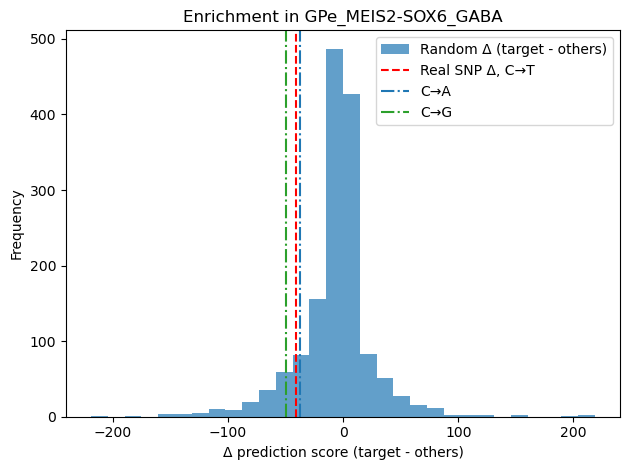

Δ control (C→A) = -37.6003
Δ control (C→G) = -49.6363


In [27]:
original_pred, mutated_pred, sequence, mutated_sequence, SNP_position, start, ref_nucleotide = plot_variant_specific_scores(peaks_below_500, snp, pheno, genome, model)

mutation = mutated_sequence[SNP_position - start]
print("Ref Nucelotide", ref_nucleotide)
print("Mutation", mutation)

mutation_all_central_bases(original_pred, mutated_pred, sequence, mutated_sequence, 
                              cell_type, adata, 
                              ref_base = ref_nucleotide, mutation = mutation)

#### Comparison with the effect across all cell types

In [ ]:
def CT_specific_mutation_plot(original_pred, mutated_pred):

    delta = original_pred - mutated_pred
    cell_types = list(adata.obs_names)

    assert len(delta) == len(cell_types), "Length mismatch between predictions and cell types"

    plt.figure(figsize=(12,5))
    plt.bar(range(len(delta)), delta)
    plt.xticks(ticks = range(len(cell_types)), labels = cell_types, rotation = 90)
    plt.ylabel("Δ prediction score (mutated - original)")
    plt.title("Impact of SNP on predicted regulatory activity across cell types")
    plt.tight_layout()
    #plt.savefig(f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/figures/CRESTED_figures/Delta_predicted_scores_{snp}_{pheno}_{cell_type}.svg")
    plt.show()

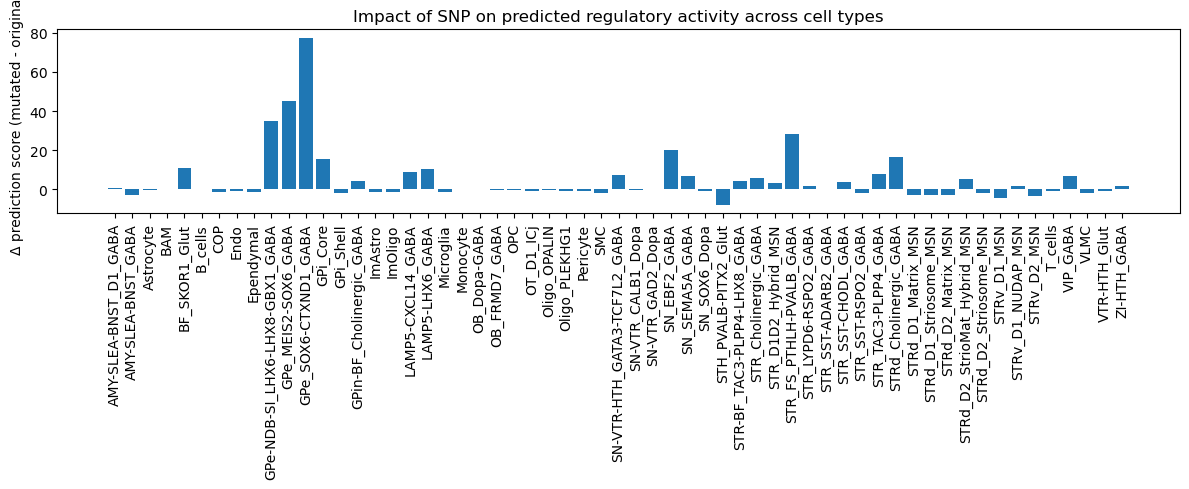

In [29]:
CT_specific_mutation_plot(original_pred, mutated_pred)